In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

In [2]:
image = cv2.imread("./data/level_3.jpg", cv2.IMREAD_COLOR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

# ぼかし処理
gray_gb = cv2.GaussianBlur(gray, None, 3.0)

# 大津の二値化
thr, binary = cv2.threshold(gray_gb, 0, 255, cv2.THRESH_OTSU)
new_thr = min(int(thr * 1.05), 255)
_, binary = cv2.threshold(gray, new_thr, 255, cv2.THRESH_BINARY)
plt.imshow(binary, cmap="gray")
plt.title("Otsu's binarization (threshold={:d})".format(int(thr)))
plt.show()

error: OpenCV(4.8.1) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


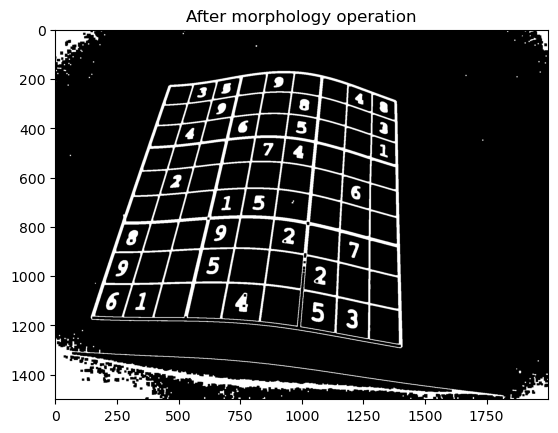

In [ ]:
edge = cv2.Canny(binary, 100, 200)
edge = cv2.dilate(edge, np.ones((11, 11), dtype=edge.dtype))
edge = cv2.erode(edge, np.ones((9, 9), dtype=edge.dtype))
# res_close = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((5, 5), dtype=binary.dtype))
plt.imshow(edge, cmap="gray")
plt.title("After morphology operation".format(thr))
plt.show()

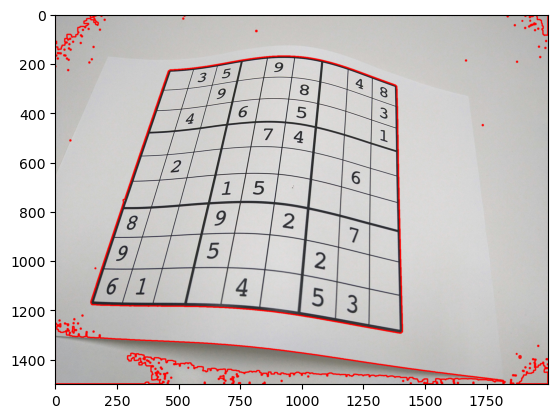

In [ ]:
contours, _ = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
result = image.copy()
cv2.drawContours(result, contours, -1, (255, 0, 0), 3, cv2.LINE_AA)
plt.imshow(result)
plt.show()

1282


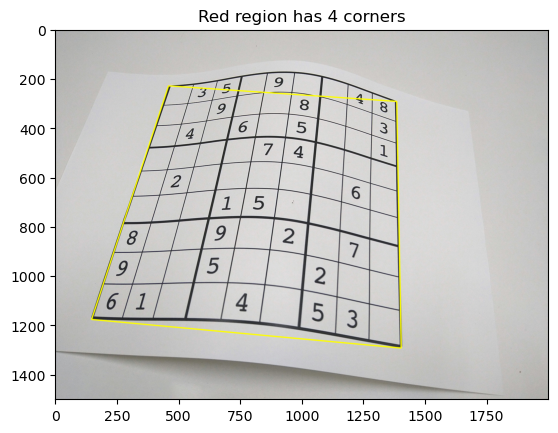

[[[1386  293]]

 [[ 460  230]]

 [[ 148 1177]]

 [[1404 1293]]]


In [ ]:
longest_cnt = None
max_length = 0.0
max_area = 0.0
result = image.copy()
for cnt in contours:
    # 輪郭線の長さを計算
    arclen = cv2.arcLength(cnt, True)
    approx=cv2.approxPolyDP(cnt, arclen * 5.0e-2, True)
    area=cv2.contourArea(cnt)
    x, y, w, h = cv2.boundingRect(approx)
    internal_area_ratio = area / (w * h)
    if len(approx) >= 4 and internal_area_ratio>0.5:
        # print(len(approx), x,y,w,h, arclen,internal_area_ratio)
        cv2.drawContours(result, [approx], -1, (255, 0, 0), 3, cv2.LINE_AA)
        # plt.imshow(result)
        # plt.show()
        if  max_area < area:
            max_area = area
            max_length = arclen
            longest_cnt = cnt
result = image.copy()

# plt.imshow(result)
# plt.show()
print(len(longest_cnt))
arclen = cv2.arcLength(longest_cnt, True)
approx = cv2.approxPolyDP(longest_cnt, arclen * 5.0e-2, True)

cv2.drawContours(result, [approx], -1, (255, 255, 0), 3, cv2.LINE_AA)
plt.imshow(result)
plt.title("Red region has {:d} corners".format(len(approx)))
plt.show()
print(approx)

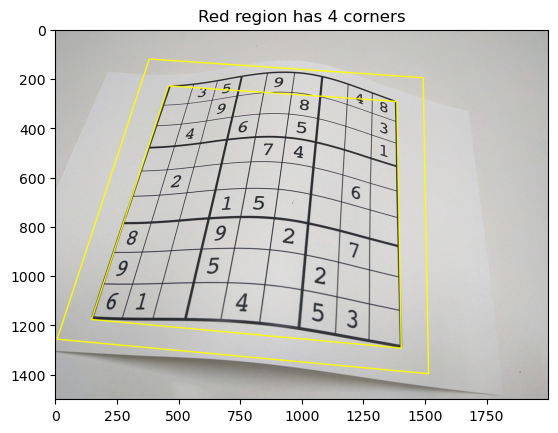

In [ ]:
# 輪郭線の重心を計算する
M = cv2.moments(approx)
cx = int(M['m10'] / M['m00'])
cy = int(M['m01'] / M['m00'])

# 各点に対して、重心からの距離を計算し、1.1倍した点を取得する
new_approx = []
for point in approx:
    x, y = point[0]
    dist = np.sqrt((cx - x)**2 + (cy - y)**2)
    dist_new = dist * 1.2
    x_new = int(cx - dist_new * (cx - x) / dist)
    y_new = int(cy - dist_new * (cy - y) / dist)
    new_approx.append([[x_new, y_new]])

# 新しい近似を描画する
new_approx = np.array(new_approx)
cv2.drawContours(result, [np.array(new_approx)], -1, (255, 255, 0), 3, cv2.LINE_AA)
plt.imshow(result)
plt.title("Red region has {:d} corners".format(len(new_approx)))
plt.show()

[[1493.  197.]
 [ 382.  121.]
 [   8. 1257.]
 [1515. 1397.]]


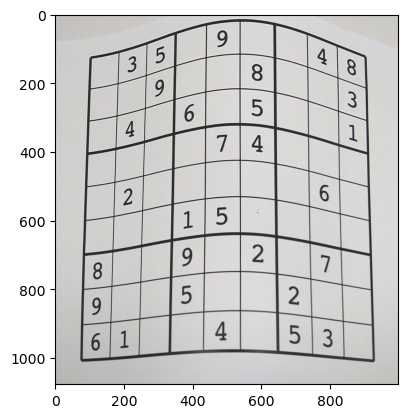

In [ ]:
from sklearn.preprocessing import StandardScaler
x, y, w, h = cv2.boundingRect(np.array(new_approx))

src_pts=np.array(new_approx.reshape(-1,2), dtype="float32")
# src_pts = np.array([approx[0], approx[1], approx[2], approx[3]], dtype="float32")
print(src_pts)
# 縦横比の計算
w = np.linalg.norm(src_pts[3] - src_pts[0])
h = np.linalg.norm(src_pts[1] - src_pts[0])
aspect = abs(w) / abs(h)

# 新しい画像サイズを設定
new_w = int(1000 *aspect)
new_h = 1000
dst_pts = np.array([(0, 0), (0, new_h), (new_w, new_h), (new_w, 0)], dtype="float32")

# 射影変換を計算して、パースをキャンセルする

result = cv2.copyMakeBorder(result, 50, 50, 50, 50, cv2.BORDER_CONSTANT, value=(255, 255, 255))
warp = cv2.getPerspectiveTransform(src_pts, dst_pts)
result = cv2.warpPerspective(image, warp, (new_w, new_h))
# result = cv2.warpPerspective(binary, warp, (new_w, new_h))

#　反転させたリストを作成
results=[result, cv2.rotate(result,cv2.ROTATE_90_CLOCKWISE), cv2.rotate(result,cv2.ROTATE_180), cv2.rotate(result,cv2.ROTATE_90_COUNTERCLOCKWISE)]
# for i, result in enumerate(results):

#     plt.subplot(2, 2, i+1)
#     plt.imshow(result)
#     plt.title("result {:d}".format(i))
result=cv2.rotate(result,cv2.ROTATE_90_CLOCKWISE)
plt.imshow(result, cmap="gray")
plt.show()

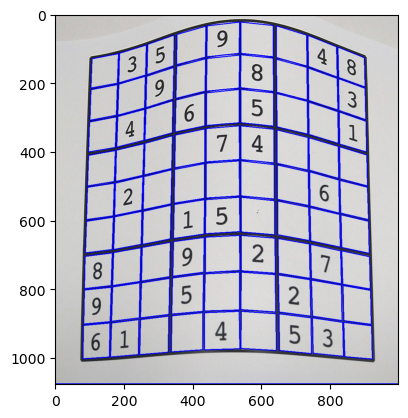

In [ ]:
# 正方形を検出する
# 画像をグレースケールに変換する
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)

# 大津の二値化を適用
thresh, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)

# 輪郭を検出する
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# 正方形を検出する
result = result.copy()
for cnt in contours:
    # 輪郭線の近似を行う
    arclen = cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, arclen * 0.02, True)
    if len(approx) == 4:
        # 各辺の長さを計算する
        sides = []
        for i in range(4):
            x1, y1 = approx[i][0]
            x2, y2 = approx[(i + 1) % 4][0]
            side = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
            sides.append(side)

        # 各辺の長さがほぼ等しい場合、正方形とみなす
        if np.std(sides) < np.mean(sides) * 0.15:
            cv2.drawContours(result, [approx], -1, (0,0,255), 2)
plt.imshow(result)

[[0.69 0.31]] 0
[[0.89 0.11]] 0
[[0.97 0.03]] 0
[[0.7 0.3]] 0


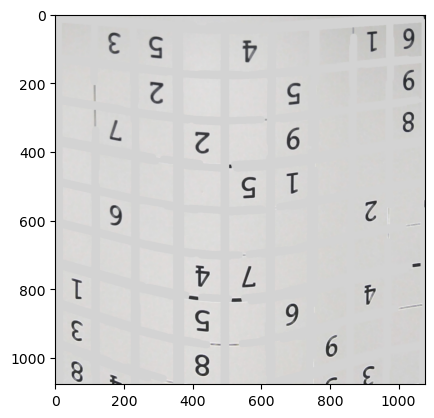

In [ ]:
import cv2
import numpy as np
# scaler_f=pd.read_pickle("./pickle/knn_scaler_flip.pickle")
# clf_f=pd.read_pickle("./pickle/knn_clf_flip.pickle")
scaler_f=pd.read_pickle("./pickle/rf_flip_scaler.pickle")
clf_f=pd.read_pickle("./pickle/rf_clf_flip.pickle")
problems=[]
flip_proba=[]
for result in results:
    # result: RGB
    ## get mean white
    # 画像を読み込む

    cropped = result.copy()
    h,w,_=cropped.shape
    cropped_rs=cv2.resize(cropped,(max(h,w),max(h,w)),interpolation=cv2.INTER_AREA)
    cropped_gr=cv2.cvtColor(result, cv2.COLOR_RGB2GRAY)
    pixel=60
    # 大津の二値化を適用
    thresh, binary_image = cv2.threshold(cropped_gr, 0, 255, cv2.THRESH_OTSU)
    # 白い領域の平均値を計算
    white_region = cropped.copy()
    white_region[binary_image == 0] = 0  # 二値化された画像で黒（0）の部分が白い領域
    mean_white = np.mean(white_region[white_region > 0])
    # print("白い領域の平均値:", mean_white)
    plt.imshow(cropped_rs)
    # plt.show()
    edges = cv2.Canny(cropped_rs, threshold1=50, threshold2=150)
    new_h, new_w,_ = cropped_rs.shape
    # Hough直線変換を適用して直線を検出
    lines = cv2.HoughLinesP(
        edges, 
        rho=1, 
        theta=np.pi / 180, 
        threshold=60,  # 閾値を調整
        minLineLength=min(new_h/9,new_w/9)*0.55,  # 線分の最小長さを設定
        maxLineGap=18  # 同じ直線とみなす最大の間隔を設定
    )

    # 検出した直線を削除
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(cropped_rs, (x1, y1), (x2, y2), (mean_white,mean_white,mean_white), 20)  # 直線を白で描画


    plt.imshow(cropped_rs)
    # plt.show()
    # 内側の細い線を塗りつぶす
    # closing
    cropped_cl = cv2.dilate(cropped_rs, np.ones((2, 2), dtype=edge.dtype),iterations=4)
    cropped_cl= cv2.erode(cropped_cl, np.ones((2, 2), dtype=edge.dtype),iterations=4)
    # opening
    # tmp = cv2.erode(cropped_region, np.ones((1, 1), dtype=edge.dtype),iterations=2)
    # tmp = cv2.dilate(tmp, np.ones((1, 1), dtype=edge.dtype))


    plt.imshow(cropped_cl,cmap="gray")
    # plt.show()
    # otsu
    cropped_cl_gr=cv2.cvtColor(cropped_cl, cv2.COLOR_RGB2GRAY)
    thr, binary = cv2.threshold(cropped_cl_gr, 0, 255, cv2.THRESH_OTSU)
    # new_thr = min(int(thr * 1.3), 255)
    # _, binary = cv2.threshold(cropped_region_gr, new_thr, 255, cv2.THRESH_BINARY)
    # ok


    binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((5, 5), dtype=binary.dtype),iterations=1)
    binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, np.ones((5, 5), dtype=binary.dtype),iterations=1)
    # plt.imshow(binary,cmap="gray")
    # plt.show()

    height, width = binary.shape

    # トリミングする範囲を計算
    trim_percentage = 0.005  # 外側を.5%トリミング
    trim_width = int(width * trim_percentage)
    trim_height = int(height * trim_percentage)
    binary = binary[trim_height:height-trim_height, trim_width:width-trim_width]

    binary=cv2.resize(binary,(pixel*9,pixel*9),interpolation=cv2.INTER_AREA)
    binary=cv2.bitwise_not(binary)
    # cropped_rs=cv2.morphologyEx(cropped_rs, cv2.MORPH_CLOSE, np.ones((3, 3), dtype=binary.dtype),iterations=1)

    # whether it is flipped or not
    digit=cv2.resize(binary,(200,200),interpolation=cv2.INTER_AREA)
    digit=digit.reshape(1,-1)
    digit=scaler_f.transform(digit)
    pred=clf_f.predict_proba(digit)
    print(pred,np.argmax(pred))
    flip_proba.append(pred[0][1])
    flag=np.argmax(pred)
    if flag:
        plt.imshow(binary,cmap="gray")
        plt.show()
    
    # plt.imshow(cropped_rs[i*pixel:(i+1)*pixel, j*pixel:(j+1)*pixel], cmap='gray')
    # plt.imshow(cropped_rs, cmap='gray')
    # cropped_rs.shape
    scaler = pd.read_pickle('./pickle/rf_scaler.pickle')
    clf=pd.read_pickle('./pickle/rf_clf.pickle')


    predicted_digits = []
    for i in range(9):
        for j in range(9):
            digit_square = binary[i*pixel:(i+1)*pixel, j*pixel:(j+1)*pixel]
            # plt.imshow(cropped_region_[i*pixel:(i+1)*pixel, j*pixel:(j+1)*pixel])
            if np.mean(digit_square)<=10:
                predicted_digits.append(0)
                continue
            digit_square = digit_square.reshape(1, -1)/255.0
            digit_square=scaler.transform(digit_square)

            # print(digit_square.shape)
            # digit_square = np.expand_dims(digit_square, axis=0)
            # print(digit_square.shape)
            prediction = clf.predict(digit_square)
            predicted_digit = np.argmax(prediction)
            predicted_digits.append(prediction[0])
    problem=[]
    for i in range(0, len(predicted_digits), 9):
        problem.append(predicted_digits[i:i+9])
        # print(predicted_digits[i:i+9])
    problems.append(problem)
    # if flag:
    #     output=problem
    # nonzeros=np.count_nonzero(predicted_digits)
    # nonzero_elements=[i for i in predicted_digits if i!=0]
    # # 最も多い数字の数
    # most_common=np.bincount(predicted_digits)[1:].argmax()+1
    # var=np.var(nonzero_elements)
    # print(nonzeros,var,most_common)

In [ ]:
no_flip_idx=np.argmax(flip_proba)
print(no_flip_idx)
problem=problems[no_flip_idx]
problem

0


[[9, 7, 9, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 7, 0, 1, 0, 7],
 [0, 0, 0, 0, 0, 0, 0, 4, 1],
 [2, 6, 9, 0, 0, 4, 1, 0, 0],
 [0, 0, 6, 0, 1, 0, 0, 0, 2],
 [0, 1, 0, 0, 0, 1, 1, 1, 0],
 [1, 0, 0, 0, 0, 0, 0, 0, 0],
 [5, 0, 6, 0, 4, 0, 0, 0, 2],
 [0, 0, 0, 0, 0, 0, 9, 7, 6]]

In [ ]:
matrix_data = [ [0, 3, 5, 0, 9, 0, 0, 4, 8],
                [0, 0, 9, 0, 0, 8, 0, 0, 3],
                [0, 4, 0, 6, 0, 5, 0, 0, 1],
                [0, 0, 0, 0, 7, 4, 0, 0, 0],
                [0, 2, 0, 0, 0, 0, 0, 6, 0],
                [0, 0, 0, 1, 5, 0, 0, 0, 0],
                [8, 0, 0, 9, 0, 2, 0, 7, 0],
                [9, 0, 0, 5, 0, 0, 2, 0, 0],
                [6, 1, 0, 0, 4, 0, 5, 3, 0]]
validate=[matrix_data[i][j]==problem[i][j] for i in range(9) for j in range(9)]
proba=sum(validate)/len(validate)
zeros=np.sum(np.array(matrix_data) == 0)
nonzeros=81-zeros
failed=81-proba*81
print(proba,failed,f"failure rate: {failed/nonzeros:.2f}")

0.41975308641975306 47.0 failure rate: 1.57


In [ ]:
for i in range(9):
    print(validate[i*9:i*9+9])

[False, False, False, True, False, True, True, False, False]
[True, True, False, True, False, False, False, True, False]
[True, False, True, False, True, False, True, False, True]
[False, False, False, True, False, True, False, True, True]
[True, False, False, True, False, True, True, False, False]
[True, False, True, False, False, False, False, False, True]
[False, True, True, False, True, False, True, False, True]
[False, True, False, False, False, True, False, True, False]
[False, False, True, True, False, True, False, False, False]
